# Analyzing Pull Request Review Statistics

This notebook analyzes the last 100 pull requests you have reviewed, computes summary statistics, and visualizes the distribution of their line counts.

## 1. Import Required Libraries

We will use `requests` for API calls, `pandas` for data manipulation, and `matplotlib`/`seaborn` for visualization.

In [6]:
# Import required libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

## 2. Authenticate and Connect to GitHub API

Set up authentication using a GitHub personal access token. You can store your token in an environment variable for security.

In [ ]:
load_dotenv()

# Set up GitHub authentication
# Store your GitHub token in an environment variable named GITHUB_TOKEN
GITHUB_TOKEN = os.getenv('GITHUB_TOKEN')
if not GITHUB_TOKEN:
    raise ValueError('Please set your GitHub personal access token in the GITHUB_TOKEN environment variable.')

headers = {
    'Authorization': f'token {GITHUB_TOKEN}',
    'Accept': 'application/vnd.github+json'
}

# Set your GitHub username here
GITHUB_USERNAME = os.getenv('GITHUB_USERNAME')  # <-- Load the GITHUB_USERNAME environment variable, or replace with your GitHub username

## 3. Fetch Last 100 Reviewed Pull Requests

We will use the GitHub API to find the last 100 pull requests you have reviewed. This requires searching for PR review events by your username.

In [8]:
# Fetch the last 100 pull requests you have reviewed
# This uses the GitHub Search API to find PRs where you have submitted a review

def fetch_reviewed_prs(username, headers, max_prs=100):
    prs = []
    page = 1
    per_page = 30  # GitHub API max per_page is 100, but search API may limit results
    while len(prs) < max_prs:
        search_url = f"https://api.github.com/search/issues?q=type:pr+reviewed-by:{username}&sort=updated&order=desc&per_page={per_page}&page={page}"
        resp = requests.get(search_url, headers=headers)
        if resp.status_code != 200:
            print(f"Error fetching PRs: {resp.status_code}")
            break
        items = resp.json().get('items', [])
        if not items:
            break
        prs.extend(items)
        if len(items) < per_page:
            break
        page += 1
    return prs[:max_prs]

reviewed_prs = fetch_reviewed_prs(GITHUB_USERNAME, headers, max_prs=100)
print(f"Fetched {len(reviewed_prs)} reviewed PRs.")

Fetched 100 reviewed PRs.


## 4. Extract Line Count Data from Pull Requests

For each pull request, extract the number of lines added, deleted, and the total line count using the PR API.

In [15]:
# Extract line count data for each PR
from tqdm.autonotebook import tqdm

def extract_pr_line_counts(prs, headers):
    pr_data = []
    for pr in tqdm(prs, desc="Fetching PR details"):
        repo_full_name = pr['repository_url'].split('repos/')[-1]
        pr_number = pr['number']
        pr_url = f"https://api.github.com/repos/{repo_full_name}/pulls/{pr_number}"
        resp = requests.get(pr_url, headers=headers)
        if resp.status_code != 200:
            continue
        pr_info = resp.json()
        pr_data.append({
            'repo': repo_full_name,
            'number': pr_number,
            'title': pr['title'],
            'additions': pr_info.get('additions', 0),
            'deletions': pr_info.get('deletions', 0),
            'changed_files': pr_info.get('changed_files', 0),
            'total_changes': pr_info.get('additions', 0) + pr_info.get('deletions', 0)
        })
    return pd.DataFrame(pr_data)

pr_df = extract_pr_line_counts(reviewed_prs, headers)
pr_df.head()

/tmp/ipykernel_201998/3601448570.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Fetching PR details: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]



,repo,number,title,additions,deletions,changed_files,total_changes
0,Sage-Bionetworks/synapse-web-monorepo,2285,SWC-7496: Backfill tests for enum/autocomplete...,219,1,3,220
1,Sage-Bionetworks/synapse-web-monorepo,2286,Create configurations and symlinks to env file...,16,2,6,18
2,Sage-Bionetworks/synapse-web-monorepo,2280,SWC-7509 - send client clock on grid reconnect,590,60,6,650
3,Sage-Bionetworks/synapse-web-monorepo,2243,PORTALS-3821,242,33,3,275
4,Sage-Bionetworks/synapse-web-monorepo,2282,PORTALS-3875: initialize arcus bio portal,582,18,33,600


## 4.5. Filter to remove outliers

Very large PRs have a lot of generated changes, so they poorly represent a real code review.

In [33]:
pr_df_filtered = pr_df[pr_df['total_changes'] <= 15000]  # Filter out PRs with more than 15000 total changes

## 5. Compute Summary Statistics

Calculate mean, median, standard deviation, min, and max for PR line counts.

In [34]:
# Compute summary statistics for PR line counts
summary_stats = pr_df_filtered['total_changes'].describe()
mean = pr_df_filtered['total_changes'].mean()
median = pr_df_filtered['total_changes'].median()
print('Summary statistics for total line changes:')
print(summary_stats)
print(f"Mean: {mean:.2f}")
print(f"Median: {median}")

Summary statistics for total line changes:
count      94.000000
mean      557.351064
std       906.856104
min         2.000000
25%        40.750000
50%       219.000000
75%       510.500000
max      4290.000000
Name: total_changes, dtype: float64
Mean: 557.35
Median: 219.0


## 6. Visualize Pull Request Line Counts

We will create a histogram and a boxplot to visualize the distribution, mean, and median of PR line counts.

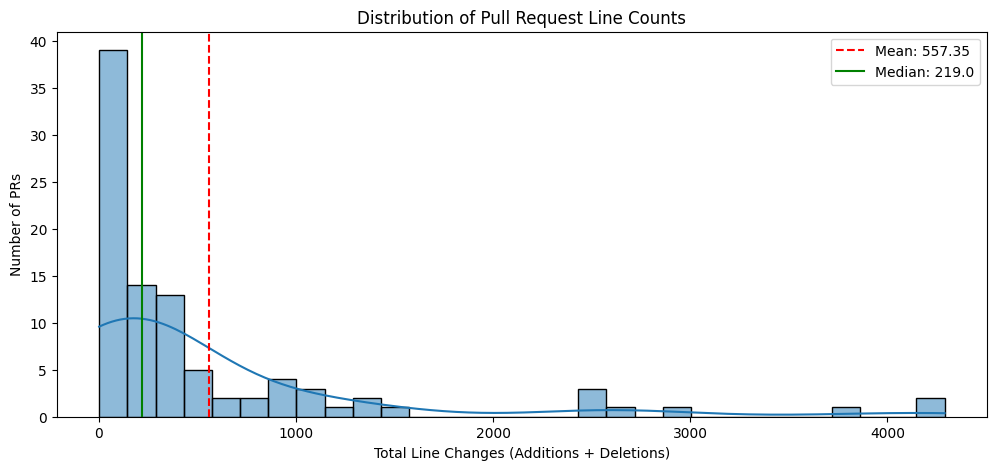

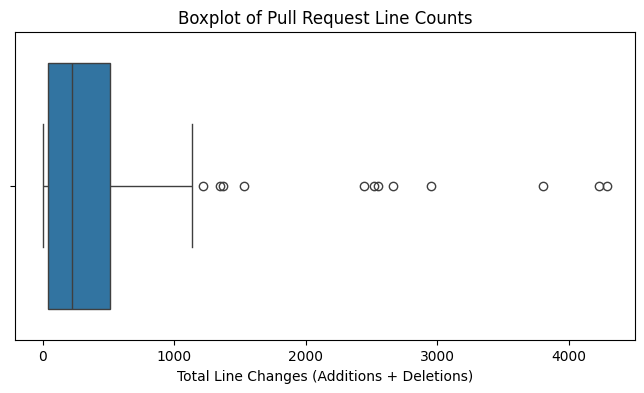

In [36]:
# Visualize the distribution of PR line counts
plt.figure(figsize=(12, 5))
sns.histplot(pr_df_filtered['total_changes'], bins=30, kde=True)
plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='g', linestyle='-', label=f'Median: {median}')
plt.title('Distribution of Pull Request Line Counts')
plt.xlabel('Total Line Changes (Additions + Deletions)')
plt.ylabel('Number of PRs')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=pr_df_filtered['total_changes'])
plt.title('Boxplot of Pull Request Line Counts')
plt.xlabel('Total Line Changes (Additions + Deletions)')
plt.show()